# DS 5110 Final Project
## Youtube Trending Video Views Prediction
### Group 9:
### Hannah Lee (hjl8kb) | Spencer Bozsik (sb9es) | Ryan Pindale (mwp8zy)


In [1]:
#Importing necessary packages

import os
import numpy as np
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.functions import col,isnan, when, count, date_format
from pyspark.sql.functions import *
from pyspark.sql.functions import log
from pyspark.sql import SQLContext
from pyspark.sql.types import IntegerType,BooleanType,DateType



import matplotlib.style as style
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter
style.available
style.use('ggplot')


#change directory
os.chdir('/project/ds5559/group_9_data/youtube-data-with-permissions')





# Data Import and Preprocessing

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("comm") \
        .getOrCreate()

data_file = 'YouTube_Final_Data.csv'

YouTube_df = spark.read.csv(data_file, header='true', inferSchema='true')

In [3]:
#Cleaning the comments disabled column and dropping ambigous rows
YouTube_df = YouTube_df.withColumn("comments_disabled", when(YouTube_df.comments_disabled == "FALSE","False") \
      .when(YouTube_df.comments_disabled == "TRUE","True") \
      .otherwise(YouTube_df.comments_disabled))

YouTube_df2 = YouTube_df.filter(YouTube_df.comments_disabled == 'True')
YouTube_df3 = YouTube_df.filter(YouTube_df.comments_disabled == 'False')


YouTube_final = YouTube_df2.union(YouTube_df3)

#Doing the same for ratings disabled
YouTube_final = YouTube_final.withColumn("ratings_disabled", when(YouTube_df.ratings_disabled == "FALSE","False") \
      .when(YouTube_final.ratings_disabled == "TRUE","True") \
      .otherwise(YouTube_final.ratings_disabled))

#doing the same for video error or removed
YouTube_final = YouTube_final.withColumn("video_error_or_removed", when(YouTube_df.video_error_or_removed == "FALSE","False") \
      .when(YouTube_final.video_error_or_removed == "TRUE","True") \
      .otherwise(YouTube_final.video_error_or_removed))




In [4]:
'''
here we're trying to figure out where there are missing values. Appears to be a lot of missing values but
it doesn't matter a ton to us because we're going to focus on the description first

Code adapted from: https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/
'''
from pyspark.sql.functions import col,isnan, when, count
YouTube_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in YouTube_final.columns]
   ).show()

+--------+-------------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+--------------+-----------------+----------------+----------------------+-----------+
|video_id|trending_date|title|channel_title|category_id|publish_time|tags|views|likes|dislikes|comment_count|thumbnail_link|comments_disabled|ratings_disabled|video_error_or_removed|description|
+--------+-------------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+--------------+-----------------+----------------+----------------------+-----------+
|       0|            0|    0|            0|          0|           0|   0|    0|    0|       0|            0|             0|                0|               0|                     0|       1071|
+--------+-------------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+--------------+-----------------+----------------+----------------------+-----------+



# Data Splitting/Sampling

In [5]:
Train, Test = YouTube_final.randomSplit([0.8, 0.2], seed=314)

# Exploratory data analysis with at least 2 graphs

### Also feature engineering before modeling

Note: EDA is done on the training set. Feature engineering is done on both training and testing set.

In [6]:
'''
Casting strings as numeric. Not sure why this was giving me issues like this but casting so we can do
correlation matrix
'''
Numeric_only  = Train.select("views","likes","dislikes","comment_count")
Numeric_only = Numeric_only.withColumn("views",col("views").cast("int"))
Numeric_only = Numeric_only.withColumn("likes",col("likes").cast("int"))
Numeric_only = Numeric_only.withColumn("dislikes",col("dislikes").cast("int"))
Numeric_only = Numeric_only.withColumn("comment_count",col("comment_count").cast("int"))
Numeric_only


'''
Got the correlation matrix for our numeric features.
https://stackoverflow.com/questions/52214404/how-to-get-the-correlation-matrix-of-a-pyspark-data-frame
We can see here that numeric features are pretty heavily correlated. 
'''

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=Numeric_only.columns, outputCol=vector_col)
df_vector = assembler.transform(Numeric_only).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
matrix.collect()[0]["pearson({})".format(vector_col)].values

array([1.        , 0.77495913, 0.38198759, 0.4582678 , 0.77495913,
       1.        , 0.43108449, 0.73265786, 0.38198759, 0.43108449,
       1.        , 0.77585984, 0.4582678 , 0.73265786, 0.77585984,
       1.        ])

In [7]:
#Selecting columns to explore for EDA
yt = Train
yt = yt.drop('video_id').drop('thumbnail_link').drop('video_error_or_removed')

yt = yt.withColumn('trend_date',to_date(yt.trending_date,'yy.dd.mm')).drop('trending_date')

yt = yt.withColumn('category_id',yt.category_id.cast(IntegerType()))
yt = yt.withColumn('views',yt.views.cast(IntegerType()))
yt = yt.withColumn('likes',yt.likes.cast(IntegerType()))
yt = yt.withColumn('dislikes',yt.dislikes.cast(IntegerType()))
yt = yt.withColumn('comment_count',yt.comment_count.cast(IntegerType()))

yt = yt.withColumn("day_of_week", date_format(col("publish_time"), "EEEE"))


yt.registerTempTable('yt_table')
sqlContext = SQLContext(spark)
yt1 = sqlContext.sql("SELECT * from yt_table").toPandas()

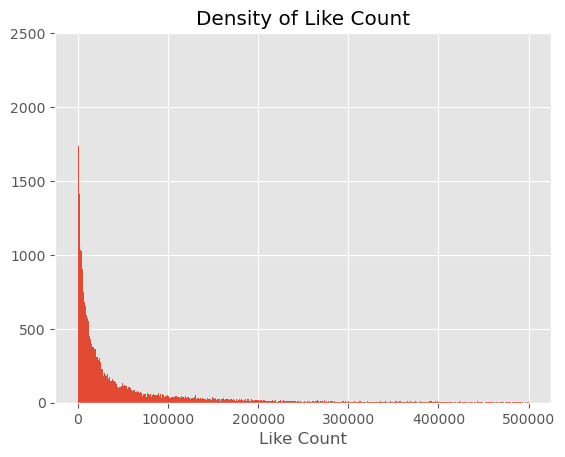

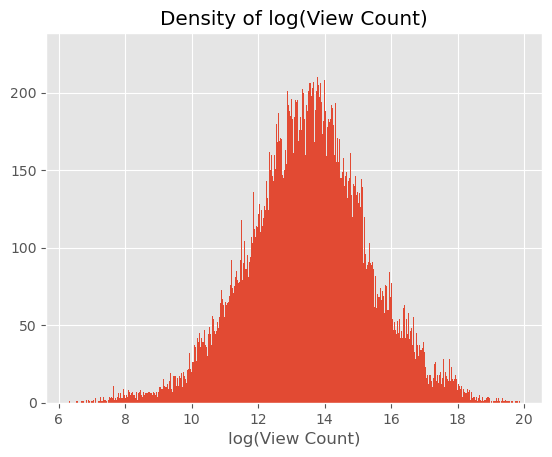

In [8]:
plt.hist(yt1.likes,bins=1000,range=(0,500000))
plt.ylim([0,2500])
plt.title('Density of Like Count')
plt.xlabel('Like Count')
plt.show()

# log tranformed for normality
plt.hist(np.log(yt1.views),bins=1000)
plt.title('Density of log(View Count)')
plt.xlabel('log(View Count)')
plt.show()

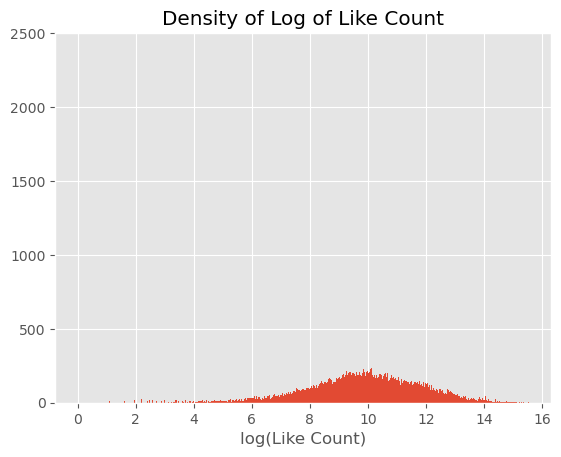

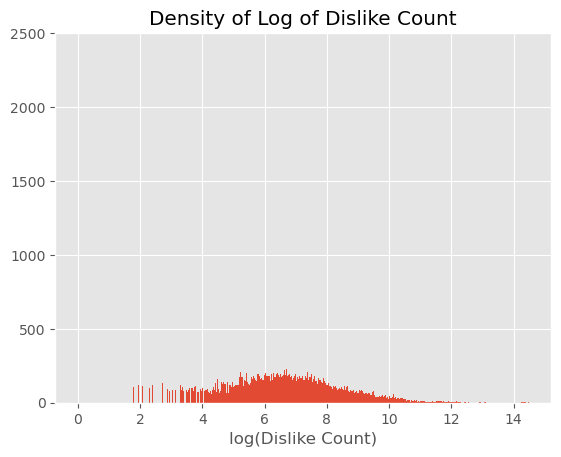

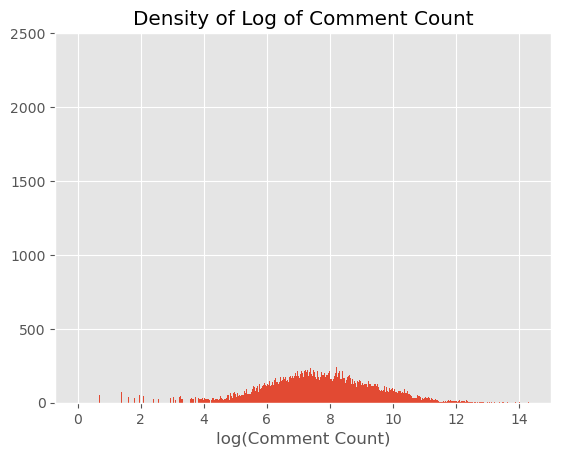

In [9]:
like_no_zero = [x for x in yt1.likes if x!=0]
plt.hist(np.log(like_no_zero),bins=1000)
plt.ylim([0,2500])
plt.title('Density of Log of Like Count')
plt.xlabel('log(Like Count)')
plt.show()

dislike_no_zero = [x for x in yt1.dislikes if x!=0]
plt.hist(np.log(dislike_no_zero),bins=1000)
plt.ylim([0,2500])
plt.title('Density of Log of Dislike Count')
plt.xlabel('log(Dislike Count)')
plt.show()

comment_count_no_zero = [x for x in yt1.comment_count if x!=0]
plt.hist(np.log(comment_count_no_zero),bins=1000)
plt.ylim([0,2500])
plt.title('Density of Log of Comment Count')
plt.xlabel('log(Comment Count)')
plt.show()

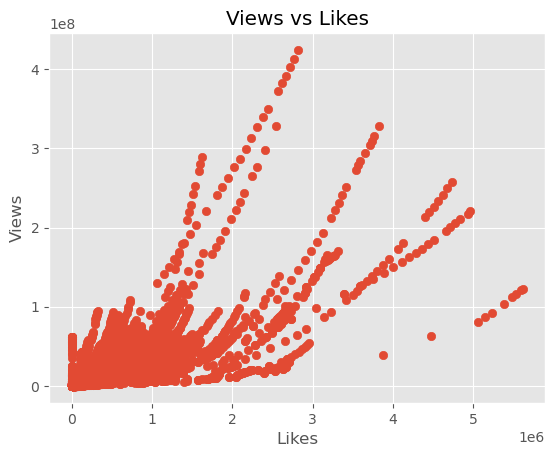

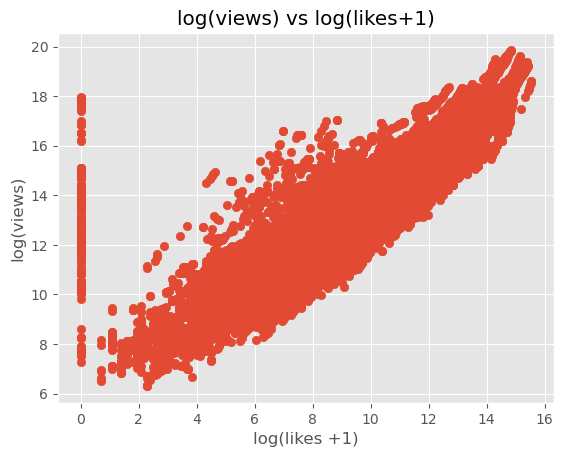

In [10]:
plt.scatter(yt1.likes,yt1.views)
plt.title('Views vs Likes')
plt.xlabel('Likes')
plt.ylabel('Views')
plt.show()


plt.scatter(np.log(yt1.likes+1),np.log(yt1.views))
plt.title('log(views) vs log(likes+1)')
plt.xlabel('log(likes +1)')
plt.ylabel('log(views)')
plt.show()

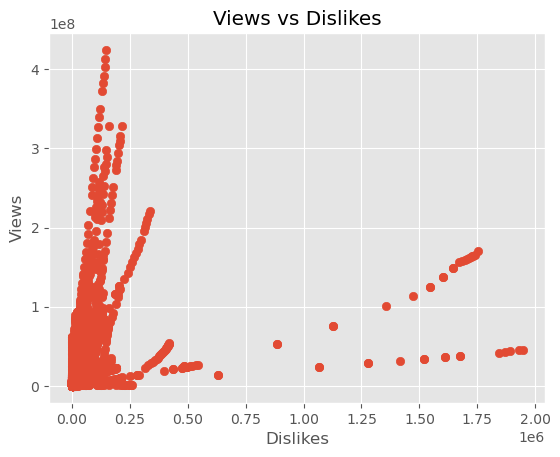

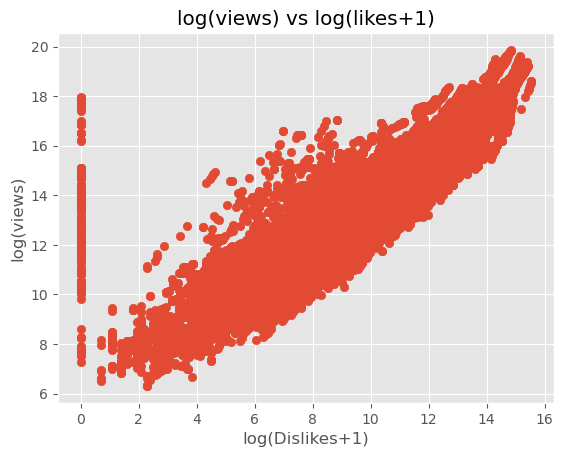

In [11]:
plt.scatter(yt1.dislikes,yt1.views)
plt.title('Views vs Dislikes')
plt.xlabel('Dislikes')
plt.ylabel('Views')
plt.show()


plt.scatter(np.log(yt1.likes+1),np.log(yt1.views))
plt.title('log(views) vs log(likes+1)')
plt.xlabel('log(Dislikes+1)')
plt.ylabel('log(views)')
plt.show()

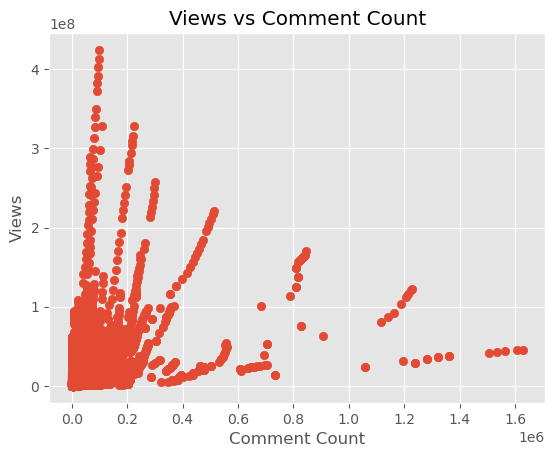

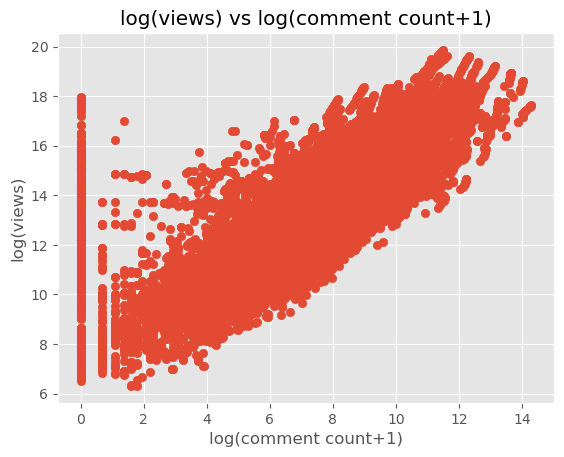

In [12]:
plt.scatter(yt1.comment_count,yt1.views)
plt.title('Views vs Comment Count')
plt.xlabel('Comment Count')
plt.ylabel('Views')
plt.show()


plt.scatter(np.log(yt1.comment_count+1),np.log(yt1.views))
plt.title('log(views) vs log(comment count+1)')
plt.xlabel('log(comment count+1)')
plt.ylabel('log(views)')
plt.show()


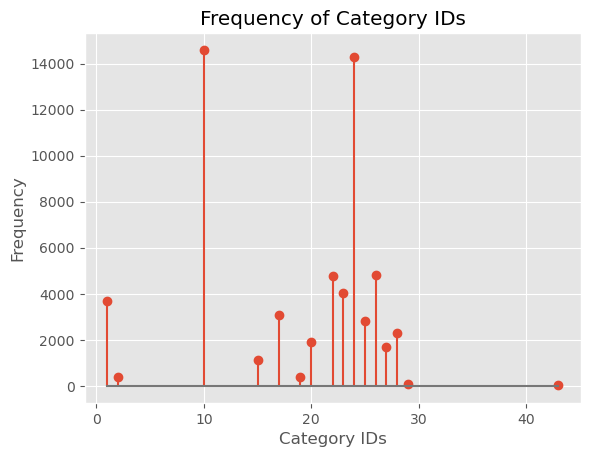

In [13]:
category = pd.DataFrame(yt1.category_id.value_counts()).reset_index()
top_ten_cat = category.sort_values('category_id',ascending=False).iloc[0:9,:]
plt.stem(category['index'],category.category_id)
plt.xlabel('Category IDs')
plt.ylabel('Frequency')
plt.title('Frequency of Category IDs')
plt.show()

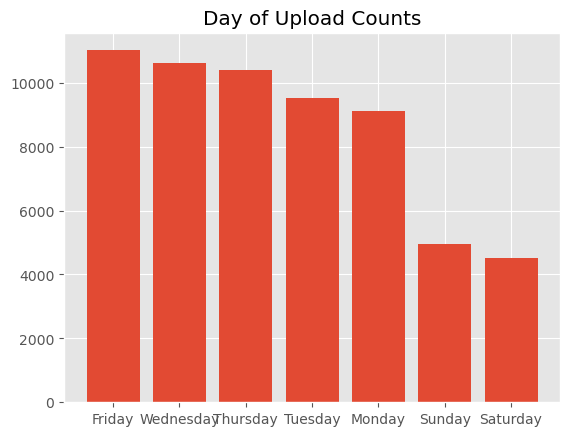

In [14]:
plt.bar(yt1.day_of_week.value_counts().keys(),yt1.day_of_week.value_counts().values)
plt.title('Day of Upload Counts')
plt.show()

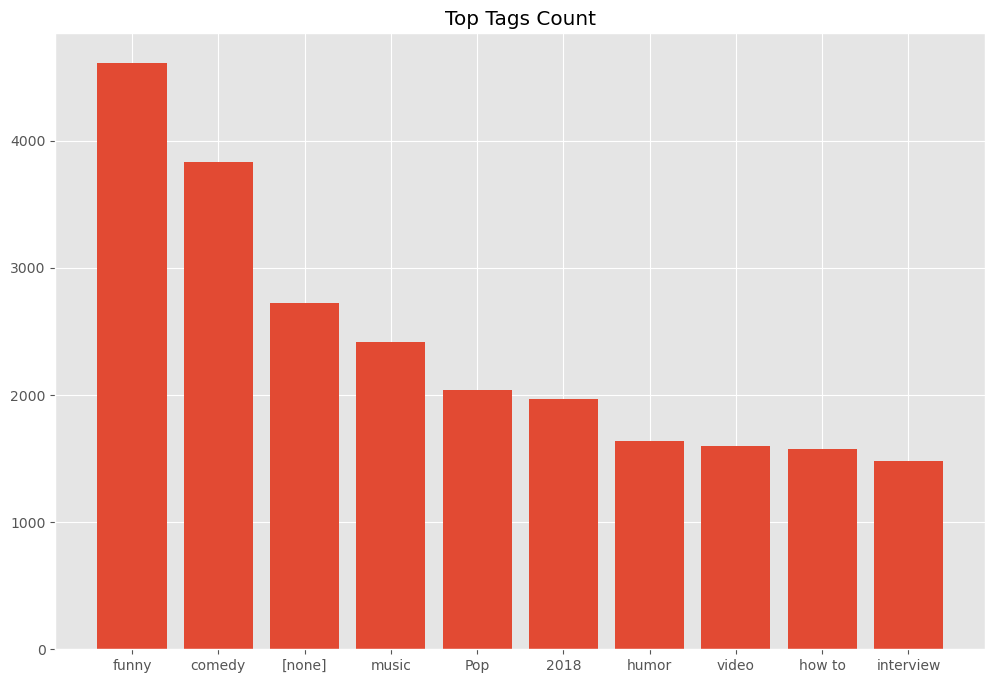

In [15]:
tags_combined =[x.split('""|""') for x in yt1.tags]
tags = list(pd.Series(tags_combined).explode())
tag_list = list(pd.Series([x.replace('"','').split('|') for x in tags]).explode())

top_tags = dict(Counter(tag_list).most_common()[0:10])

figure(figsize=(12, 8))
plt.bar(top_tags.keys(),top_tags.values())
plt.title('Top Tags Count')
plt.show()

After looking at the plots of predictor distributions and their relationship with the target (views), it looks like log(views) could be a more suitible predictor for a basic linear regression model. Also, log(likes+1), log(comment_count+1), log(dislikes+1) have a near linear relationship to log(views). Categorical and Boolean predictors are also to be included.

In [16]:
'''
Creating a table with log(views), log(likes+1), 
log(dislikes+1), log(comment_count+1), days_to_trending (difference between trending date and publish time),
day_of_week, comments_disabled, ratings_disabled, 
video_error_or_removed, and category_id as predictors
'''

def get_desired_predictors(dataset):
    assemble_table  = dataset.select("views","likes","dislikes","comment_count", "comments_disabled", "ratings_disabled", 
                                           "trending_date",
                                           "video_error_or_removed", "category_id",
                                           date_format(col("publish_time"), "yyyy-MM-dd").alias("publish_time").cast("string"))
    assemble_table = assemble_table.withColumn("trending_date",to_date(col("trending_date"),"yy.dd.MM"))
    assemble_table = assemble_table.withColumn("views",col("views").cast("int"))
    assemble_table = assemble_table.withColumn("log(views)",log(col("views")))
    assemble_table = assemble_table.withColumn("likes",col("likes").cast("int"))
    assemble_table = assemble_table.withColumn("log(likes+1)",log(col("likes")+1))
    assemble_table = assemble_table.withColumn("dislikes",col("dislikes").cast("int"))
    assemble_table = assemble_table.withColumn("log(dislikes+1)",log(col("dislikes")+1))
    assemble_table = assemble_table.withColumn("comment_count",col("comment_count").cast("int"))
    assemble_table = assemble_table.withColumn("log(comment_count+1)",log(col("comment_count")+1))
    assemble_table = assemble_table.withColumn("days_to_trending",datediff(col("trending_date"), col("publish_time")))
    assemble_table = assemble_table.withColumn("day_of_week", date_format(col("publish_time"), "EEEE"))
    
    return(assemble_table)

Train_assemble_table = get_desired_predictors(Train)
Test_assemble_table = get_desired_predictors(Test)

In [17]:
'''
Was having trouble creating dummy variables in pyspark dataframe so made it a pandas and going 
to cast it back.
https://sparkbyexamples.com/pyspark/convert-pyspark-dataframe-
to-pandas/#:~:text=PySpark%20DataFrame%20provides%20a%20method,small%20subset%20of%20the%20data.
'''

def make_dummy_cols(assemble_table_dataset):
    
    pandasDF = assemble_table_dataset.toPandas()

    pandasDF2 = pd.get_dummies(data = pandasDF, columns = ['comments_disabled', 
                                                           'ratings_disabled',
                                                           'video_error_or_removed',
                                                           'category_id',
                                                           'day_of_week'],drop_first=True)

    
    '''
    Casting back to a psypark dataframe so we can do some analysis on it 
    https://sparkbyexamples.com/pyspark/convert-pandas-to-pyspark-dataframe/
    '''
    Final_sparkDF=spark.createDataFrame(pandasDF2) 
    return(Final_sparkDF)
   
    
Train_sparkDF = make_dummy_cols(Train_assemble_table)
Test_sparkDF = make_dummy_cols(Test_assemble_table)
#Train_sparkDF.printSchema()
#Test_sparkDF.printSchema()

In [18]:
Train_sparkDF = Train_sparkDF.select(Train_sparkDF.columns[6:]).drop('log(dislikes+1)','log(comment_count+1)')

In [19]:
Train_sparkDF.head()

Row(log(views)=14.293915050932016, log(likes+1)=8.784162222270476, days_to_trending=2, comments_disabled_True=1, ratings_disabled_True=0, video_error_or_removed_True=0, category_id_10=0, category_id_15=0, category_id_17=0, category_id_19=0, category_id_2=0, category_id_20=0, category_id_22=0, category_id_23=0, category_id_24=0, category_id_25=0, category_id_26=0, category_id_27=0, category_id_28=0, category_id_29=0, category_id_43=0, day_of_week_Monday=0, day_of_week_Saturday=0, day_of_week_Sunday=1, day_of_week_Thursday=0, day_of_week_Tuesday=0, day_of_week_Wednesday=0)

## Lets check assumptions for linear regression

In [20]:
# 1: linearity (kinda)
# 2: constant variance (kinda)
# 3: no autocorrelation n/a
# 4: normality of errors (kinda)
# 5: no multicollinearity (there is)

In [21]:
test = Train_sparkDF.toPandas().drop('log(views)',axis=1)

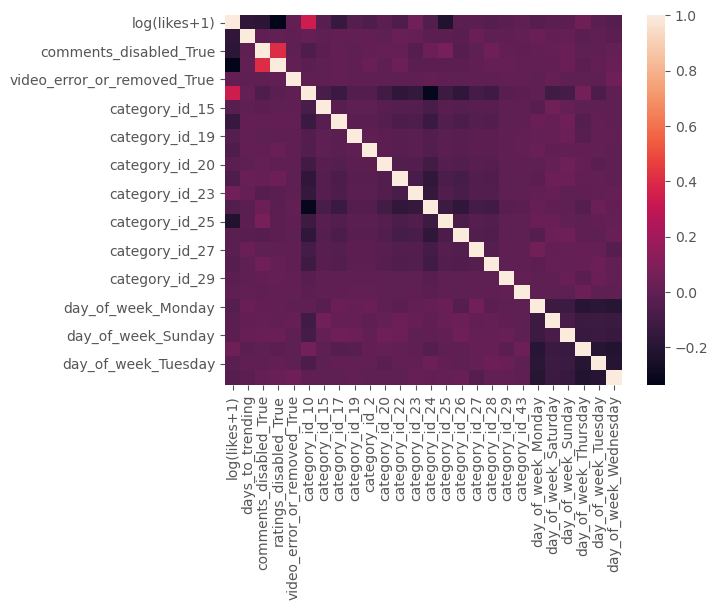

In [22]:
import seaborn as sns
sns.heatmap(test.corr())
plt.show()

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = test.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(test.values, i)
                          for i in range(len(test.columns))]
  
print(vif_data)

                        feature        VIF
0                  log(likes+1)  12.923869
1              days_to_trending   1.031626
2        comments_disabled_True   1.239335
3         ratings_disabled_True   1.257189
4   video_error_or_removed_True   1.004725
5                category_id_10   4.338367
6                category_id_15   1.186140
7                category_id_17   1.457509
8                category_id_19   1.064121
9                 category_id_2   1.059670
10               category_id_20   1.337396
11               category_id_22   1.828539
12               category_id_23   1.795635
13               category_id_24   3.522159
14               category_id_25   1.371523
15               category_id_26   1.869540
16               category_id_27   1.314755
17               category_id_28   1.407116
18               category_id_29   1.019026
19               category_id_43   1.008252
20           day_of_week_Monday   1.748208
21         day_of_week_Saturday   1.400787
22         

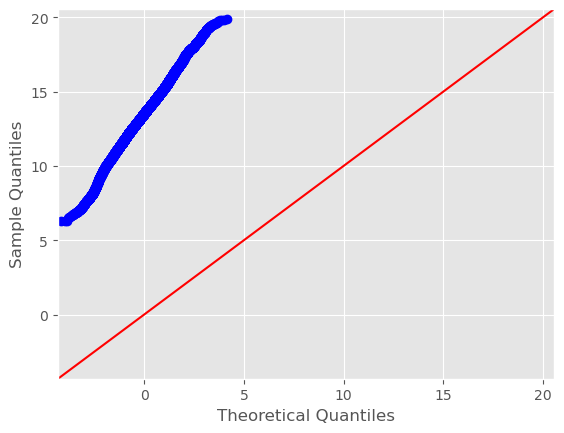

In [24]:

import numpy as np
import statsmodels.api as sm
import pylab as py  
  
sm.qqplot(np.log(yt1.views), line ='45')
py.show()

# Model Construction with at Least 3 Models

## Simple Linear regression

In [25]:
vectorAssembler = VectorAssembler(inputCols = Train_sparkDF.columns[1:], outputCol = 'features')
Train_sparkDF_vectorized = vectorAssembler.transform(Train_sparkDF).select(['features', 'log(views)'])
Test_sparkDF_vectorized = vectorAssembler.transform(Test_sparkDF).select(['features', 'log(views)'])


lr = LinearRegression(featuresCol = 'features', labelCol='log(views)')
lr_model = lr.fit(Train_sparkDF_vectorized)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.8221020948850046,0.00048258182963359456,0.5677187369659987,7.511680672637022,0.12771202699765055,-0.3269999269663813,-0.44918413157282705,0.296609480326674,0.002188667378007282,0.2123801509469564,-0.4630775112262042,-0.48612562126678877,-0.4636996879570187,-0.14748528504925856,0.17434763995371902,-0.7455632370958075,-0.6189663433355534,-0.31502766054187403,-0.7988548967869942,-0.25338943727945096,-0.01339037467534182,-0.10937932130304688,-0.0008679125052604135,0.0050594769384469575,-0.09501250857555721,-0.0935966700457363]
Intercept: 5.7359025940187305
RMSE: 0.771873
r2: 0.819737


## Random Forest Regressor

In [26]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(featuresCol='features',labelCol='log(views)')
rf_model = rf.fit(Train_sparkDF_vectorized)


## Gradient Boosted Tree Regressor

In [27]:
#did the vectorization in the linear regression code so reused here 
gbt = GBTRegressor(featuresCol='features',labelCol='log(views)', maxIter=100)
gb_model = gbt.fit(Train_sparkDF_vectorized)

# Model evaluation

## Simple Linear Regression

In [28]:
lr_predictions = lr_model.transform(Test_sparkDF_vectorized)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol='log(views)',metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

test_result = lr_model.evaluate(Test_sparkDF_vectorized)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

R Squared (R2) on test data = 0.820986
Root Mean Squared Error (RMSE) on test data = 0.772039


In [29]:
print("Mean Squared Error (MSE) on test data = %g" % test_result.meanSquaredError)
print("Mean Absolute Error (MAE) on test data = %g" % test_result.meanAbsoluteError)

Mean Squared Error (MSE) on test data = 0.596044
Mean Absolute Error (MAE) on test data = 0.581552


## Random Forest Regressor

In [30]:
rf_predictions = rf_model.transform(Test_sparkDF_vectorized)


evaluator = RegressionEvaluator(predictionCol='prediction',labelCol='log(views)')
print(evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"}),
evaluator.evaluate(rf_predictions, {evaluator.metricName: "mse"}),
evaluator.evaluate(rf_predictions, {evaluator.metricName: "rmse"}),
evaluator.evaluate(rf_predictions, {evaluator.metricName: "mae"}),
evaluator.evaluate(rf_predictions, {evaluator.metricName: "var"}))

# small difference between rmse and mae means consistent error sizes
# mae of 0.2 means that the average difference between label and predicted was 0.2

0.7209047819683025 0.929275081644602 0.9639891501695452 0.7220855432897287 1.4509530444431342


## Gradient Boosted Tree Regressor

In [31]:
#creates 100 trees sequentially
#https://spark.apache.org/docs/latest/ml-classification-regression.html
gb_predictions = gb_model.transform(Test_sparkDF_vectorized)
print(evaluator.evaluate(gb_predictions, {evaluator.metricName: "r2"}),
evaluator.evaluate(gb_predictions, {evaluator.metricName: "mse"}),
evaluator.evaluate(gb_predictions, {evaluator.metricName: "rmse"}),
evaluator.evaluate(gb_predictions, {evaluator.metricName: "mae"}),
evaluator.evaluate(gb_predictions, {evaluator.metricName: "var"}))

0.8585798041441697 0.4708725035740197 0.6862015036226747 0.5126195313525116 2.851968643651214
